# Imports

In [613]:
# handle math and data
import numpy as np
import pandas as pd
import time
import math

# visualization and plotting
from IPython import display
import matplotlib as mpl
import matplotlib.pyplot as plt

# to plot nice figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)



# handle files
import os
import sys
import joblib

# hash table classes
from collections import Counter

# output
from tqdm.notebook import tqdm
from tqdm.notebook import trange

# deep learning
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_hub as hub

# Setup

In [2]:
SEED = 69

K = keras.backend

AUTO = tf.data.AUTOTUNE

def reset_backend():
    K.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Learning

Autoencoders use an encoder and decoder to try to literally copy the training data value for value (target is the train e.g. model.fit(X_train, X_train)). In this process, the hidden layers in the encoder should learn to encode patterns, significant info, etc. about the input. The decoder also takes the coding - a vector representation of the input data - and decodes it.
- This allows for dimensionality reduction using the encoder (preserve patterns while lowering dimensionality of data)
- Unsupervised pretraining (using lower layers of encoder to train on supervised data since lower layers usually learn patterns in the autoencoder)
- Generation (using variational autoencoder where the encoder produces a mean and std for each feature or unit and a gaussian distribution is created and sampled from, the decoder tries to convert the sampled coding to the input data. Once trained, you can just generated samples yourself from the gaussian distribution and use the decoder to generate data.)

Autoencoders use constraints like dimensionality, dropout, l1 regularization, etc. to force the encoder to preserve useful patterns, otherwise it may just overfit the training data and produce near-exact replicas, but won't generalize well to new instances.

## GANs

Generative Adversarial Networks - first part of model takes a random distribution and generates an instance (like an image) while second part of model tries to classify the image as real or fake.
- Discriminator is trained on half fake and half real as a binary classifier
- Then discriminator's weights are frozen and used to predict the generator as real! The losses passed back will try to get the generator to generate fakes that are as real as possible
- By repeating this the discriminator will learn an increasing amount about the real data while the generator will similarly use the discriminator's learning to optimize and generate more realistic data

### Simple GAN

In [ ]:
train, valid, test = tfds.load("fashion_mnist", as_supervised=True, 
                               split=["train[:-5000]", "train[-5000:]", "test"])

For the GAN we only need the images, not their labels.

In [141]:
def image_only(image, label):
    resized_image = tf.reshape(image, shape=[28, 28])
    final_image = tf.cast(resized_image, tf.float32) / 255.
    return final_image

In [142]:
batch_size = 32
train_images = train.map(image_only).shuffle(55000).batch(batch_size, drop_remainder=True).prefetch(1)

Our generator will take a random distribution and return a fashion mnist image
- Input is `coding_size`
- Dense layers
- Dense output `784`
- Reshape to `[28, 28]`

In [143]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[codings_size]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"), # basically darkness of pixel scaled 0 to 1
    keras.layers.Reshape([28, 28]),
])

Our discriminator will take the image and do binary classification
- Input is `[28,28]`
- Dense layers
- Dense layer with sigmoid and 1 unit

In [144]:
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[28, 28]),
    keras.layers.Flatten(),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

Our GAN will just be a combo of the two, but used to train the generator.

In [145]:
gan = keras.models.Sequential([
    generator,
    discriminator,
])

When compiling, since our training will train discriminator and the gan separately we want to compile it twice.

In [146]:
discriminator.compile(loss="binary_crossentropy",
                      optimizer="rmsprop")

# trainable is only used pre-compilation, so discriminator will be trainable on itself, but frozen in the gan
discriminator.trainable = False
gan.compile(loss="binary_crossentropy",
            optimizer="rmsprop")

Since our training will occur in two steps, we do need some sort of custom loop.

In [147]:
for img in train_images.take(1):
    pass
img.shape

TensorShape([32, 28, 28])

In [148]:
img.dtype

tf.float32

In [149]:
# takes (batch_size, 28, 28) and plots all images
def plot_image(batch_img):
    n_cols = 6
    n_rows = (len(batch_img) - 1) // n_cols + 1
    plt.figure(figsize=(18, n_rows * 3))
    for index, img in enumerate(batch_img):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(img, cmap="binary")
        plt.axis("off")

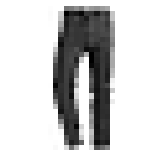

In [150]:
plot_image([img[0]])

In [169]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    with trange(1, n_epochs + 1, desc="Epochs") as epochs:
        for epoch in epochs:
            for X_batch in tqdm(dataset, desc="Epoch {}/{}".format(epoch, n_epochs)):
                # phase 1 - training the discriminator
                noise = tf.random.normal(shape=[batch_size, codings_size])
                generated_images = generator(noise) # (batch_size, 28, 28)
                print("Generated shape: ", generated_images.shape)
                print("Real images shape: ", X_batch.shape)
                X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) # (2*batch_size, 28, 28)
                y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # (2*batch_size, 1)
                discriminator.trainable = True # not necessary just explicit
                discriminator.train_on_batch(X_fake_and_real, y1)

                # phase 2 - training the generator
                noise = tf.random.normal(shape=[batch_size, codings_size])
                y2 = tf.constant([[1.]] * batch_size) # (batch_size, 1)
                discriminator.trainable = False
                gan.train_on_batch(noise, y2)

Now let's train our model.

In [ ]:
train_gan(gan, train_images, batch_size, codings_size, n_epochs=50)

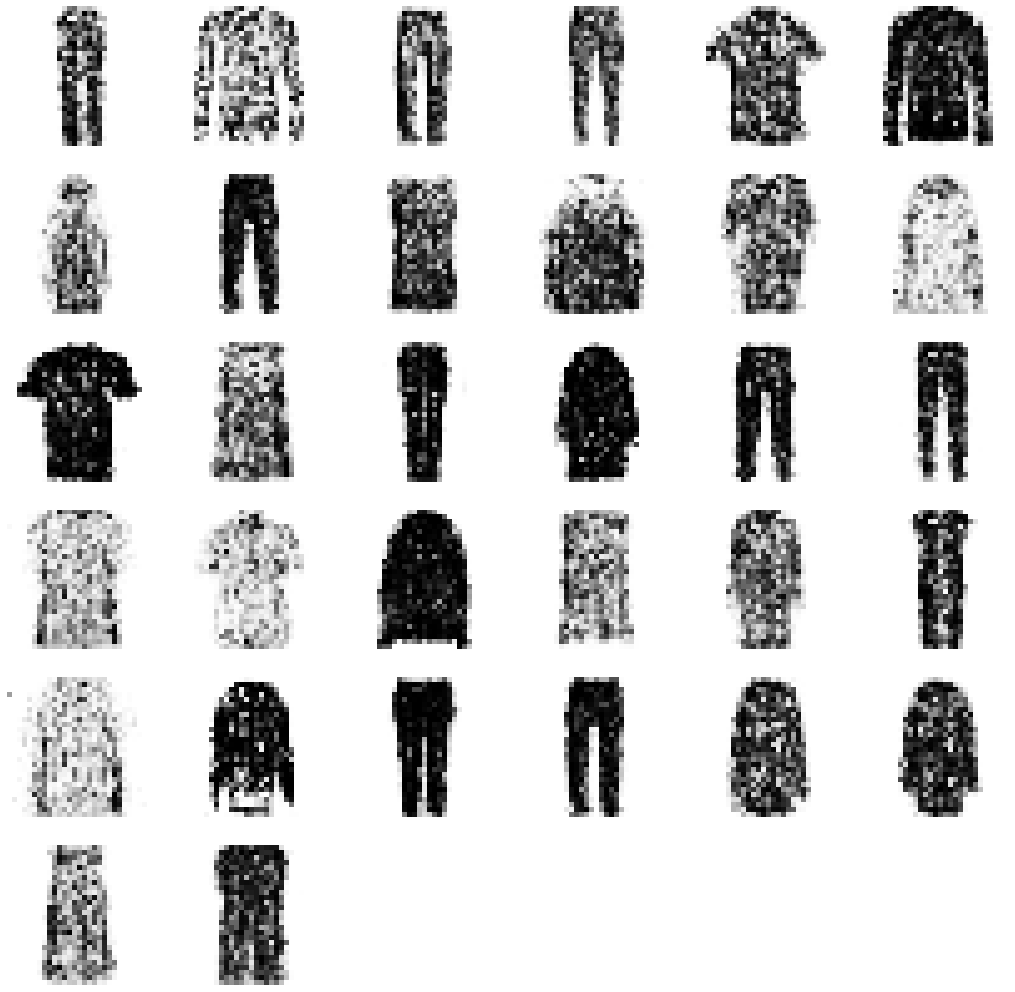

In [155]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_image(generated_images)

### DCGAN

Despite training for 50 epochs, our simple gan did not improve much from just 1 epoch of training. This is due to mode collapse, when the generator gets really good at generating one class of images because it beats the discriminator. Then when the discriminator catches up, the generator will have to move on to another class, while forgetting the previously learned class. To fix this, the hyperparameters of the model must be tuned to perfection - the Deep Convolutional GAN architecture works.

- Generator takes random distribution codings
- Codings go through reshaping to `(rows, cols, channels)`
- Upsample using Conv2DTranspose
- Return `(28, 28, 1)` using tanh activation (tanh is from -1 to 1 so standardize your data)
- Discriminator takes image `(28, 28, 1)`
- Learns patterns with Conv2D and downsamples with stride
- Flatten
- Dense sigmoid

In [157]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[codings_size]),
    keras.layers.Dense(7 * 7 * 128), # no activation
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, 
                                 padding="same", activation="selu"),  # upsampled from (7, 7, 128) to (14, 14, 64)
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, 
                                 padding="same", activation="tanh") # upsampled from (14, 14, 64) to (28, 28, 1)
])

discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[28, 28, 1]),
    keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, 
                        padding="same", 
                        activation=keras.layers.LeakyReLU(alpha=0.2)), # downsampled from (28, 28, 1) to (14, 14, 64)
    keras.layers.Dropout(0.4), # dropout instead of BN to make more stable
    keras.layers.Conv2D(filters=128, kernel_size=5, strides=2,
                        padding="same",
                        activation=keras.layers.LeakyReLU(alpha=0.2)), # downsample from (14, 14, 64) to (7, 7, 128)
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([
    generator,
    discriminator
])

We need our data to be from -1 to 1 since the generator is using the tanh activation function.

In [162]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    scaled_image = (image / 255.) * 2. - 1.
    return scaled_image

In [171]:
batch_size = 32
train_set = train.map(preprocess).shuffle(55000).batch(batch_size, drop_remainder=True).prefetch(1)

In [166]:
for img_batch in train_set.take(1):
    pass
img_batch.shape

TensorShape([32, 28, 28, 1])

Compile and train using the same function above.

In [164]:
discriminator.trainable = True
discriminator.compile(loss="binary_crossentropy",
                      optimizer="rmsprop")

discriminator.trainable = False
gan.compile(loss="binary_crossentropy",
            optimizer="rmsprop")

Train

In [172]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    with trange(1, n_epochs + 1, desc="Epochs") as epochs:
        for epoch in epochs:
            for X_batch in tqdm(dataset, desc="Epoch {}/{}".format(epoch, n_epochs)):
                # phase 1 - training the discriminator
                noise = tf.random.normal(shape=[batch_size, codings_size])
                generated_images = generator(noise) # (batch_size, 28, 28, 1)
                X_fake_and_real = tf.concat([generated_images, X_batch], axis=0) # (2*batch_size, 28, 28, 1)
                y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # (2*batch_size, 1)
                discriminator.trainable = True # not necessary just explicit
                discriminator.train_on_batch(X_fake_and_real, y1)

                # phase 2 - training the generator
                noise = tf.random.normal(shape=[batch_size, codings_size])
                y2 = tf.constant([[1.]] * batch_size) # (batch_size, 1)
                discriminator.trainable = False
                gan.train_on_batch(noise, y2)

In [ ]:
train_gan(gan, train_set, batch_size, codings_size, n_epochs=50)

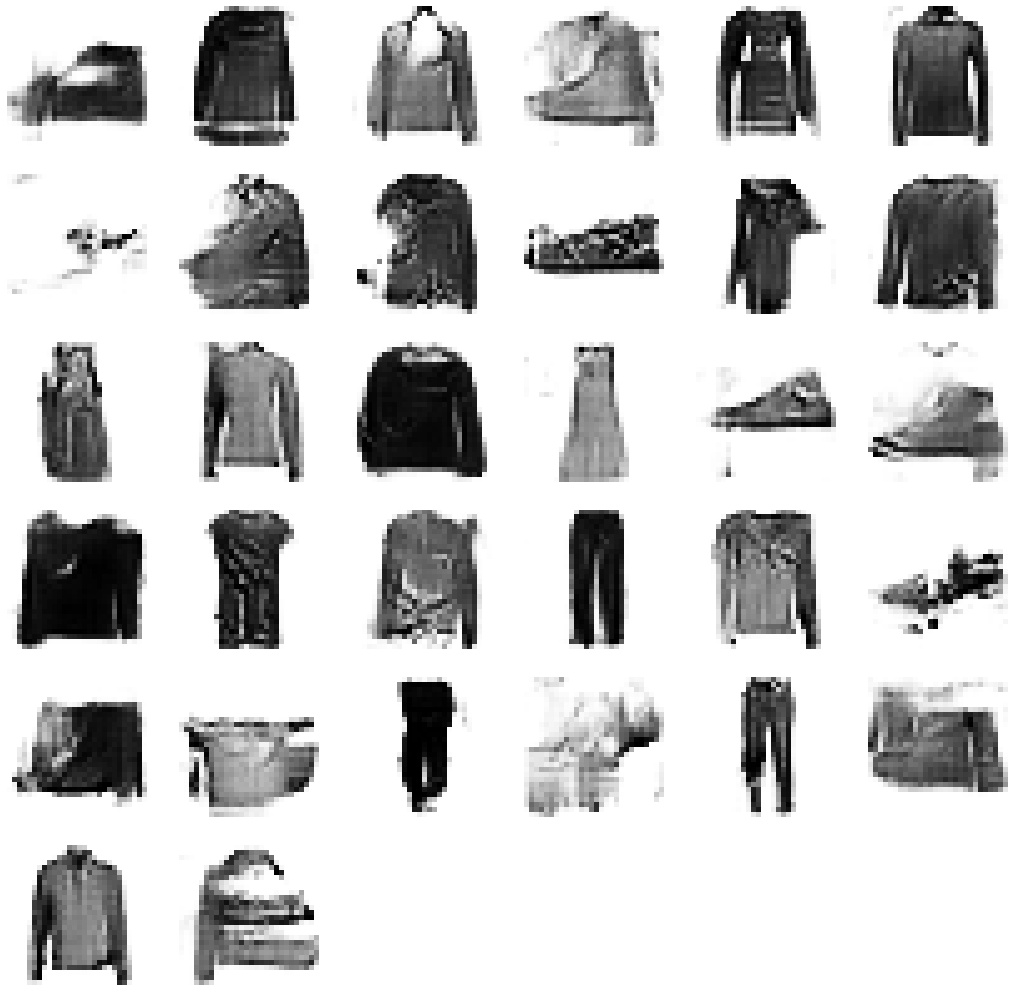

In [174]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_image(generated_images)

Indeed, the DCGAN is much more effective after training for only 5 epochs!

# Exercises

## Denoising CIFAR10

Unsupervised pretraining using a denoising autoencoder to build a classification DNN on CIFAR10 dataset.

### The Data

#### Load from Keras

First get the data.

In [179]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [180]:
X_train.shape

(50000, 32, 32, 3)

In [195]:
y_train.shape

(50000, 1)

In [181]:
X_test.shape

(10000, 32, 32, 3)

#### Visualize images

In [190]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog",
               "frog", "horse", "ship", "truck"]

In [226]:
def plot_image(X_batch, y_batch=None):
    n_cols = 6
    n_rows = (len(batch) - 1) // n_cols + 1
    plt.figure(figsize=(12, 2 * n_rows))
    for index, image in enumerate(X_batch):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        if isinstance(y_batch, np.ndarray):
            plt.title(class_names[y_batch[index][0]]) # if y_batch is (batch_size, 1) instead of (batch_size,)
        plt.axis("off")

Let's visualize an instance.

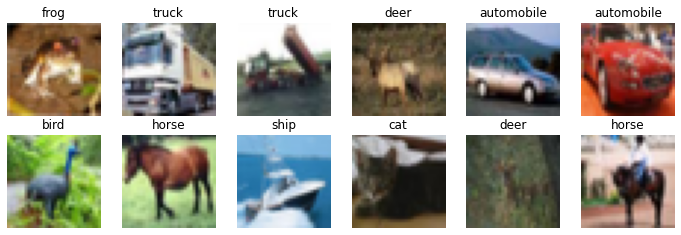

In [227]:
plot_image(X_train[:12], y_train[:12])

Ok so the images are 32x32 pixels with 3 color channels.

#### Preprocess Data

We will need to standardize our pixel values and return the image as both input and target for our denoising autoencoder.

In [259]:
def preprocess(image):
    tf_image = tf.cast(image, dtype=tf.float32)
    scaled_image = tf_image / 255.
    return scaled_image, scaled_image # copy second one?

In [260]:
preprocess(X_train[0])

(<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
 array([[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],
 
        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],
 
        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],
 
        ...,
 
        [[0.8156863 , 0.6666667 , 

#### Create tf dataset

In [342]:
batch_size = 32

train_set = tf.data.Dataset.from_tensor_slices(
    X_train).map(preprocess).shuffle(50000).batch(batch_size).prefetch(1)
test_set = tf.data.Dataset.from_tensor_slices(
    X_test).map(preprocess).batch(batch_size).prefetch(1)

Let's see what one batch looks like.

In [264]:
for batch in train_set.take(1):
    pass
len(batch), batch[0].shape, batch[0].dtype, batch[1].shape, batch[1].dtype

(2,
 TensorShape([32, 32, 32, 3]),
 tf.float32,
 TensorShape([32, 32, 32, 3]),
 tf.float32)

### Autoencoder

We want a denoising autoencoder.
- Encoder
    - Input `[32, 32, 3]`
    - Flatten
    - Dropout 0.5
    - Dense layers
    - codings_size = 100
- Decoder
    - Input `100`
    - Dense layers
    - Reshape `[32, 32, 3]`

Let's use a simple one first, if it performs poorly we can try using convolutional ae.

It performed poorly, let's use convolutional.

#### Denoising Autoencoder

Use rounded accuracy measure.

In [302]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Model architecture.

In [329]:
denoising_encoder = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[32, 32, 3]),
    keras.layers.GaussianNoise(0.1),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(), # 16, 16, 32
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

denoising_decoder = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[512]),
    keras.layers.Dense(16 * 16 * 32, activation="relu"),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])

#### Test denoising ae

Now let's run this for a few epochs and visualize the reconstructions.

In [ ]:
optimizer = keras.optimizers.Nadam()
denoising_ae.compile(loss="binary_crossentropy",
                   optimizer=optimizer,
                   metrics=[rounded_accuracy, "mse"])
denoising_ae.fit(train_set, epochs=20)

#### Reconstruction

Let's create a function for visualizing reconstruction.

In [345]:
for test_batch, _ in test_set.take(1):
    pass
test_batch.shape

TensorShape([32, 32, 32, 3])

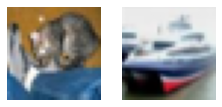

In [346]:
plot_image(test_batch[:2])

Make sure to scale the data.

In [347]:
reconstructions = denoising_ae.predict(test_batch)

1/1 [==============================] - 0s 27ms/step


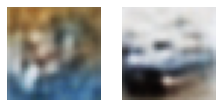

In [348]:
plot_image(reconstructions[:2])

1/1 [==============================] - 0s 21ms/step


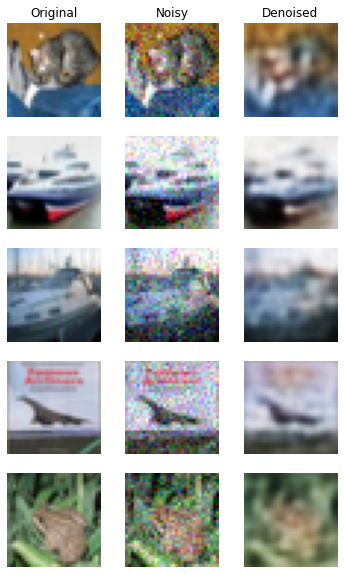

In [349]:
n_images = 5
new_images = test_batch[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

### Classification DNN with Unsupervised Pretraining

Let's try to build a classification DNN with a limited 500 labeled images by reusing the lower layers of the autoencoder.

#### Create ClDataset

Let's create normal classification dataset first.

In [383]:
# validation set
X_valid, X_test_clf = X_test[:5000], X_test[5000:]
y_valid, y_test_clf = y_test[:5000], y_test[5000:]

In [389]:
def preprocess(X_batch, y_batch):
    # scale X to 0 to 1 and convert both to float tensors
    X = tf.cast(X_batch, tf.float32) / 255.
    y = tf.cast(y_batch, tf.float32)
    return X, y

In [402]:
batch_size = 32

clf_train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(
    50000).batch(batch_size).map(preprocess).prefetch(1)
clf_train_set_500 = tf.data.Dataset.from_tensor_slices((X_train[:500], y_train[:500])).shuffle(
    500).batch(batch_size).map(preprocess).prefetch(1)
clf_valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size).map(preprocess).prefetch(1)
clf_test_set = tf.data.Dataset.from_tensor_slices((X_test_clf, y_test_clf)).batch(batch_size).map(preprocess).prefetch(1)

#### Baseline Model

Let's train a normal model on 500 instances without pretraining.

In [409]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[32, 32, 3]),
    keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=1024, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=10, activation="softmax")
])

Compile.

In [404]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

Use tensorboard and early stopping.

In [405]:
LOGDIR = os.path.join(".", "_tf_logs", "16_ae_gan")
os.makedirs(LOGDIR, exist_ok=True)

In [406]:
run_index = 1
run_logdir = os.path.join(LOGDIR, "clf_baseline_model_run_{:05d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)
print(run_logdir)

./_tf_logs/16_ae_gan/clf_baseline_model_run_00001


In [407]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)

Train

In [408]:
model.fit(clf_train_set_500, epochs=50, 
          validation_data=clf_valid_set,
          callbacks=[tensorboard_cb, early_stopping_cb])

Epoch 1/50
16/16 [==============================] - 4s 206ms/step - loss: 3.4549 - accuracy: 0.2520 - val_loss: 2.3427 - val_accuracy: 0.1394
Epoch 2/50
16/16 [==============================] - 3s 200ms/step - loss: 0.8581 - accuracy: 0.7200 - val_loss: 2.2868 - val_accuracy: 0.1648
Epoch 3/50
16/16 [==============================] - 3s 216ms/step - loss: 0.3357 - accuracy: 0.8900 - val_loss: 2.3483 - val_accuracy: 0.2020
Epoch 4/50
16/16 [==============================] - 3s 202ms/step - loss: 0.1853 - accuracy: 0.9420 - val_loss: 2.6039 - val_accuracy: 0.1126
Epoch 5/50
16/16 [==============================] - 3s 200ms/step - loss: 0.0676 - accuracy: 0.9900 - val_loss: 2.6432 - val_accuracy: 0.1242
Epoch 6/50
16/16 [==============================] - 3s 209ms/step - loss: 0.0392 - accuracy: 0.9940 - val_loss: 2.8796 - val_accuracy: 0.1132
Epoch 7/50
16/16 [==============================] - 3s 211ms/step - loss: 0.0243 - accuracy: 0.9960 - val_loss: 3.1167 - val_accuracy: 0.1140
Epoch 

Yep, as expected, 500 is way too few.

#### Unsupervised Pretraining

- Reuse the encoder's layers 
- Add our softmax on top of encoder's layers

In [439]:
pretrained_layers = denoising_encoder.layers[1:]
pretrained_layers

In [458]:
for layer in pretrained_layers:
    layer.trainable = False

In [459]:
inputs = keras.layers.Input(shape=[32, 32, 3])
z = pretrained_layers[0](inputs)
for layer in pretrained_layers[1:]:
    z = layer(z)
z = keras.layers.Dense(300, activation="relu")(z)
z = keras.layers.Dense(200, activation="relu")(z)
outputs = keras.layers.Dense(10, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], 
                           outputs=[outputs])

Compile

In [460]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

Callbacks

In [461]:
run_index = 5
run_logdir = os.path.join(LOGDIR, "clf_pretrained_model_run_{:05d}".format(run_index))
print(run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)

./_tf_logs/16_ae_gan/clf_pretrained_model_run_00005


In [462]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)

Train

In [463]:
model.fit(clf_train_set, epochs=20,
          validation_data=clf_valid_set,
          callbacks=[tensorboard_cb, early_stopping_cb])

Epoch 1/20
1563/1563 [==============================] - 17s 10ms/step - loss: 1.7216 - accuracy: 0.3899 - val_loss: 1.6023 - val_accuracy: 0.4344
Epoch 2/20
1563/1563 [==============================] - 17s 11ms/step - loss: 1.5043 - accuracy: 0.4672 - val_loss: 1.4614 - val_accuracy: 0.4866
Epoch 3/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.4045 - accuracy: 0.5000 - val_loss: 1.3822 - val_accuracy: 0.5108
Epoch 4/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.3393 - accuracy: 0.5244 - val_loss: 1.3739 - val_accuracy: 0.5156
Epoch 5/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.2856 - accuracy: 0.5430 - val_loss: 1.3716 - val_accuracy: 0.5168
Epoch 6/20
1563/1563 [==============================] - 15s 10ms/step - loss: 1.2389 - accuracy: 0.5572 - val_loss: 1.3448 - val_accuracy: 0.5272
Epoch 7/20
1563/1563 [==============================] - 15s 10ms/step - loss: 1.2046 - accuracy: 0.5696 - val_loss: 1.3482 -

In [435]:
# below is result from 500 image dataset
model.evaluate(clf_test_set)

157/157 [==============================] - 1s 5ms/step - loss: 2.0211 - accuracy: 0.2950


[2.02107834815979, 0.29499998688697815]

So, about 2 to 3 times more accurate than without unsupervised pretraining. But the best way is still to get more labeled training data.

In [464]:
# from full dataset
model.evaluate(clf_test_set)

157/157 [==============================] - 1s 7ms/step - loss: 1.3895 - accuracy: 0.5196


[1.3894832134246826, 0.519599974155426]

A good model architecture should be designed before pre-training - then use pretraining while copying the early layers of the model arhcitecture.

## Variational Autoencoder

- Get unlabeled image data
- Process data
- Train variational autoencoder till reconstruction is good
- Try to generate new images with random distribution

### The Data

Let's reuse cifar10 for this one.

In [473]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

#### Create tf dataset

In [477]:
def preprocess(X_batch):
    X = tf.cast(X_batch, tf.float32) / 255.
    return X, X

In [480]:
batch_size = 32

train_set = tf.data.Dataset.from_tensor_slices(X_train).shuffle(
    50000).batch(batch_size).map(preprocess).prefetch(1)

### Variational Autoencoder

- Encoder returns a mean and log_var
- Sample coding from mean and log_var
- Decoder takes coding and tries to return the input
- Trained using both reconstruction loss and the latent loss
    - Latent loss is a measure of the KL divergence between the encoder's mean and log_var distribution and the desired mean and variance - that of a normal Gaussian distribution

#### Encoder

For our encoder architecture, let's start with two Conv2D layers to graps the patterns of the 32, 32, 3 image. Then flatten and use a normal dense layer to produce vector representations. Finally, feed the vector to two linear transformations to produce the learnable mean and variance (log_var aka log(std^2) for more numerical stability). Then sample the coding from the gaussian distribution using the mean and variance.

Sampling class that takes the means and variances for the distribution of each neuron in the codings for each element in the batch. Then samples a distribution from the mean and variances for each neuron in each batch.

In [489]:
K = keras.backend

class Sampling(keras.layers.Layer):
    """
    Returns a sampled coding of shape (batch_size, codings_size)
    """
    def call(self, inputs):
        mean, log_var = inputs
        return (K.random_normal(tf.shape(log_var))        # basically (batch_size, codings_size)
                                * K.exp(log_var / 2)     # stable version of std
                                + mean)

Now that we have our sampler, let's create our encoder.

In [491]:
codings_size = 100

inputs = keras.layers.Input(shape=[32, 32, 3])
z = keras.layers.Conv2D(filters=32, kernel_size=3, padding="same",
                        activation="selu")(inputs)
z = keras.layers.MaxPooling2D()(z)                                         # 16, 16, 32
z = keras.layers.Conv2D(filters=64, kernel_size=3, padding="same",
                        activation="selu")(z)
z = keras.layers.MaxPooling2D()(z)                                         # 8, 8, 64
z = keras.layers.Flatten()(z)
z = keras.layers.Dense(300, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(inputs=[inputs],
                                         outputs=[codings_mean, codings_log_var, codings])

#### Decoder

Our decoder is pretty simple, just take the codings and reconstruct our inputs.

In [492]:
variational_decoder = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[codings_size]),
    keras.layers.Dense(300, activation="selu"),
    keras.layers.Dense(8 * 8 * 64, activation="selu"),
    keras.layers.Reshape([8, 8, 64]),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                 padding="same", activation="selu"),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, 
                                 padding="same", activation="sigmoid"),
])

#### Autoencoder

In [493]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], 
                                    outputs=[reconstructions])

#### Latent Loss

Now we also need to add latent loss to our cost function so that the encoder will learn to output Gaussian distributions of mean = 0 and std = 1. In the process of doing so the autoencoder will learn patterns and eventually be able to take random distributions of the same shape as our codings and output images like cifar10.

In [494]:
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1) # summed across all neurons in codings (so the last axis since codings are of shape (batch_size, codings_size))

Now we just need to add the mean latent loss across the entire batch to our autoencoder, but making sure we use the right scale. Since crossentropy is the mean loss across all outputs (32 * 32 * 3 outputs), we also need to divide our sum by (32 * 32 * 3). 

In [495]:
variational_ae.add_loss(K.mean(latent_loss, axis=0) / (32. * 32. * 3.))

#### Train

Compile our autoencoder.

In [496]:
variational_ae.compile(loss="binary_crossentropy",
                       optimizer="rmsprop",
                       metrics=[rounded_accuracy, "mse"])

Using tensorboard.

In [498]:
run_index = 1
run_logdir = os.path.join(LOGDIR, "variational_ae_run_{:05d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=run_logdir)
print(run_logdir)

./_tf_logs/16_ae_gan/variational_ae_run_00001


Let's fit the model and train for 20 epochs.

In [ ]:
variational_ae.fit(train_set, epochs=20,
                   callbacks=[tensorboard_cb])

#### Visualize Reconstructions

Let's visualize the reconstructions to see how good our autoencoder performs.

In [508]:
def standardize(X_batch):
    X = tf.cast(X_batch, tf.float32) / 255.
    return X

In [509]:
test_set = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size).map(standardize).prefetch(1)

In [510]:
for batch in test_set.take(1):
    pass
batch.shape

TensorShape([32, 32, 32, 3])

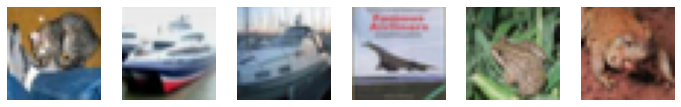

In [513]:
plot_image(batch[:6])

In [514]:
reconstructed_images = variational_ae.predict(batch)

1/1 [==============================] - 0s 213ms/step


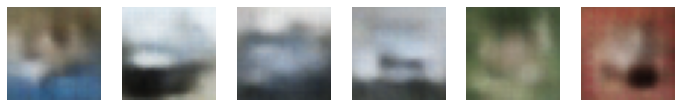

In [515]:
plot_image(reconstructed_images[:6])

In [516]:
sample_codings = tf.random.normal(shape=[batch_size, codings_size])

In [518]:
generated_images = variational_decoder.predict(sample_codings)

1/1 [==============================] - 0s 93ms/step


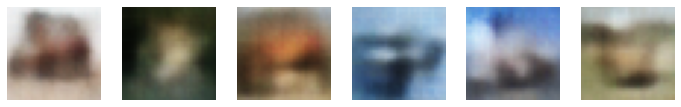

In [519]:
plot_image(generated_images[:6])

You can kind of see that the first image represents a car.

## DCGAN

Train a deep convolutional GAN to generate cifar10 images.

### The Data

We will be using the cifar10 dataset that has already been loaded.

In [521]:
X_train.shape

(50000, 32, 32, 3)

#### Preprocess

Since we will be using the tanh activation function in our generator output, we need to scale our images from 0 to 255 to -1 to 1.

In [520]:
def preprocess(X_batch):
    X_scaled = tf.cast(X_batch, tf.float32) / 255
    return (X_scaled * 2) - 1

#### Create tf dataset

Now let's create a tf.data dataset that can shuffle, batch, preprocess, and prefetch our data efficiently.

In [561]:
batch_size = 32
train_set = tf.data.Dataset.from_tensor_slices(X_train).shuffle(
    50000).batch(batch_size, drop_remainder=True).map(preprocess).prefetch(1)

In [523]:
for batch in train_set.take(1):
    pass
batch.shape

TensorShape([32, 32, 32, 3])

### DCGAN

Our model architecture is a generator, discriminator, and then the combined dcgan.

A dcgan has the following guidelines:
- Use strided convolutions instead of pooling layers
- Use batch normalization after transformation layers (dense, conv, etc.)
- Don't use fully connected hidden layers
- Use ReLU in generator's hidden layers, use tanh in generator's output layer
- Use leaky ReLU in discriminator's hidden layers, sigmoid in output layer

#### Generator

For our generator:
- Input is shape `[batch_size, codings_size]`
    - Dense with units = `4 * 4 * 128`
    - Input Reshaped to `[4, 4, 128]`
    - Batch Norm
- Conv2DTranspose
    - Batch Norm
- Conv2DTranspose
    - Batch Norm
- Output Conv2DTranspose, shape = `[32, 32, 3]`

In [626]:
codings_size = 512

generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[codings_size]),
    keras.layers.Dense(units=4 * 4 * 256),
    keras.layers.Reshape(target_shape=[4, 4, 256]),
    keras.layers.BatchNormalization(),
    # 4 --> 8
    keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding="same",
                                 activation="relu"),
    keras.layers.BatchNormalization(),
    # 8 --> 16
    keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same",
                                 activation="relu"),
    keras.layers.BatchNormalization(),
    # 16 --> 32
    keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same",
                                 activation="relu"),
    keras.layers.BatchNormalization(),
    # filters --> 3
    keras.layers.Conv2D(filters=3, kernel_size=3, padding="same",
                                 activation="tanh"),
])

#### Discriminator

For our discriminator:
- Input shape = `[32, 32, 3]`
- Conv2D shape
- Conv2D shape
- Conv2D shape
- Flatten
- Output binary classficiation layer

In [628]:
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[32, 32, 3]),
    # 32 --> 16
    keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same",
                        activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.4),
    # 16 --> 8
    keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same",
                        activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.4),
    # 8 --> 4
    keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, padding="same",
                        activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    # Flat 256
    keras.layers.Dense(units=256, activation=keras.layers.LeakyReLU(alpha=0.2)),
    # Output
    keras.layers.Dense(1, activation="sigmoid")
])

#### DCGAN

Our dcgan just combines the generator and discriminator - a model that takes a random distribution and generates fake images and classifies the images as fake or real.

In [629]:
dcgan = keras.models.Sequential([
    generator,
    discriminator
])

#### Compile

We need to train the discriminator and dcgan separately for every training step.

We want to train the discriminator to accurately detect fake and real images.

In [630]:
discriminator.trainable = True
discriminator.compile(loss="binary_crossentropy",
                      optimizer="nadam")

discriminator.trainable = False
dcgan.compile(loss="binary_crossentropy",
              optimizer="nadam")

#### Train DCGAN

Now we need to build a custom training loop.

In [639]:
def train_gan(gan, dataset, codings_size, batch_size, n_epochs):
    codings_0 = tf.random.normal(shape=[1, codings_size])
    generations_per_epoch = []
    
    for epoch in trange(1, n_epochs + 1, desc="All Epochs"):
        for X_batch in tqdm(dataset, desc="Epoch {}".format(epoch)):            
            # 1. Train discriminator
            # generate fake images
            codings = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(codings)
            assert(list(generated_images.shape) == [batch_size, 32, 32, 3])
            
            # concat fake and real images
            X_fake_real = tf.concat([generated_images, X_batch], axis=0)
            assert(X_fake_real.shape == [2*batch_size, 32, 32, 3])
            
            # create labels 0. for fake and 1. for real
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            assert(y1.shape == [2*batch_size, 1])
            
            # train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_real, y1)
            
            
            # 2. Train generator
            # create codings
            codings = tf.random.normal(shape=[batch_size, codings_size])
            
            # create labels 1. since we want generator to train as close to real as possible images
            y2 = tf.constant([[1.]] * batch_size)
            assert(y2.shape == [batch_size, 1])
            
            # train gan
            discriminator.trainable = False
            gan.train_on_batch(codings, y2)
            
            # update generator visualization
            updated_generations = (generator(codings_0) + 1) / 2
            generations_per_epoch.append(updated_generations)
    return generations_per_epoch

Now let's train!

In [640]:
generations_per_epoch = train_gan(dcgan, train_set, codings_size, 
                                  batch_size, n_epochs=1)

All Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1562 [00:00<?, ?it/s]

Let's visualize the learning over one epoch.

In [643]:
def update_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow((image[0] + 1) / 2)
    plt.axis("off")
    plt.show()

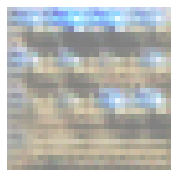

In [644]:
for image in generations_per_epoch:
    display.clear_output(wait=True)
    update_image(image)

Resume in future.